Conor Archbald - Final Project (DATr-1026) - Airbnb Price Prediction - NYC

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer

from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from scipy.stats import gaussian_kde
from scipy.stats import norm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

%matplotlib inline

In [2]:
df_original = pd.read_csv('data/AB_NYC_2019.csv')

In [3]:
# drops columns that aren't going to be useful
df = df_original
df.drop(['name', 'host_name','last_review'],axis = 1, inplace=True)

#only column that isnt completely filled is reviews_per_month. If no value, fill with 0
df.fillna(0,inplace=True)
df.isnull().sum()

#Create dummy variables and categories for visualization
df['neighbourhood_group_num'] = df.neighbourhood_group.map({'Bronx' : 0, 'Brooklyn' : 1, 'Manhattan': 2, 'Queens': 3, 'Staten Island': 4})
df['room_type_num'] = df.room_type.map({'Entire home/apt' : 0, 'Private room' : 1, 'Shared room': 2})

In [4]:
#review clean data set
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   host_id                         48895 non-null  int64  
 2   neighbourhood_group             48895 non-null  object 
 3   neighbourhood                   48895 non-null  object 
 4   latitude                        48895 non-null  float64
 5   longitude                       48895 non-null  float64
 6   room_type                       48895 non-null  object 
 7   price                           48895 non-null  int64  
 8   minimum_nights                  48895 non-null  int64  
 9   number_of_reviews               48895 non-null  int64  
 10  reviews_per_month               48895 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

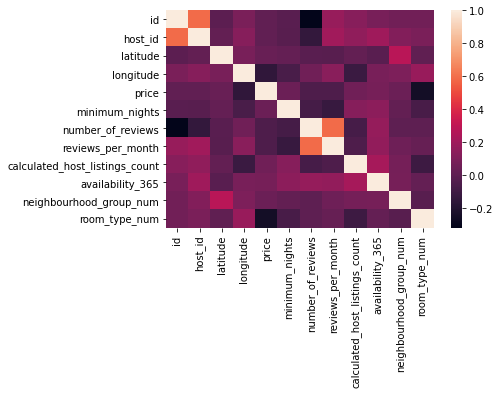

In [5]:
#start to review data and relationships
import seaborn as sns
sns.heatmap(df.corr())

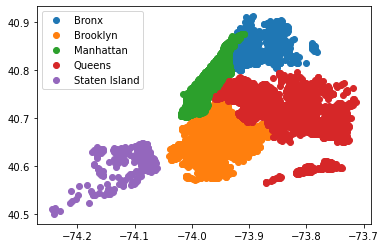

In [6]:
groups = df.groupby('neighbourhood_group')
for name, group in groups:
    plt.plot(group['longitude'], group['latitude'], marker="o", linestyle="", label=name)
    plt.legend()

In [7]:
#number of listings in each neighbourhood group
df.groupby('neighbourhood_group')['id'].count()

neighbourhood_group
Bronx             1091
Brooklyn         20104
Manhattan        21661
Queens            5666
Staten Island      373
Name: id, dtype: int64

In [8]:
#average price in each neighourhood group
df.groupby('neighbourhood_group')['price'].mean()

neighbourhood_group
Bronx             87.496792
Brooklyn         124.383207
Manhattan        196.875814
Queens            99.517649
Staten Island    114.812332
Name: price, dtype: float64

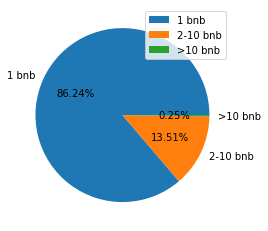

In [9]:
#number of listings held by individual agents
host_count = df['host_id'].value_counts()
bins = [0,1,10,500]
labels = ['1 bnb','2-10 bnb','>10 bnb']
host_count['host_cat'] = pd.cut(host_count, bins=bins, labels=labels)

plt.pie(host_count['host_cat'].value_counts(), labels = labels, autopct = "%0.2f%%")
plt.legend()

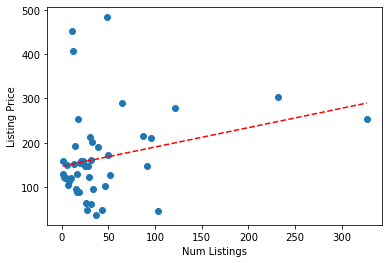

In [10]:
#plot the number of homes listed by a single host_id against the average price of the listings
host_count = df.groupby(['host_id'])[['id']].count()
host_price = df.groupby(['host_id'])[['price']].mean()
host_count_price = pd.merge(host_count, host_price, on='host_id')
price_summary = host_count_price.groupby(['id'])[['price']].mean()
price_summary = price_summary.reset_index()

plt.scatter(price_summary['id'], price_summary['price'])

z = np.polyfit(price_summary['id'], price_summary['price'], 1)
p = np.poly1d(z)
plt.plot(price_summary['id'],p(price_summary['id']),'r--')
plt.xlabel('Num Listings')
plt.ylabel("Listing Price")
plt.show()
#generally, the more listings a single host holds, the more expensive the listing will be
#likely because corporations are now willing to list on Airbnb and often have
#capital to buy up expensive real estate

Text(0.5, 1.0, 'Room Type vs Price vs Neighbourhood Group')

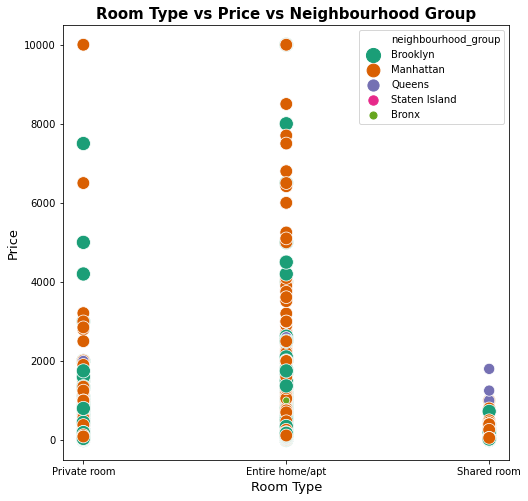

In [11]:
#Look at the price range for room type and well as neighbourhood. Highest priced outliers
#are in Manhattan and Brooklyn
plt.figure(figsize=(8,8))
sns.scatterplot(x="room_type", y="price",
            hue="neighbourhood_group", size="neighbourhood_group",
            sizes=(50, 200), palette="Dark2", data=df)

plt.xlabel("Room Type", size=13)
plt.ylabel("Price", size=13)
plt.title("Room Type vs Price vs Neighbourhood Group",size=15, weight='bold')

<ipython-input-12-671d38db130e>:9: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(x_den, y_den, c=z, s=100, edgecolor='')


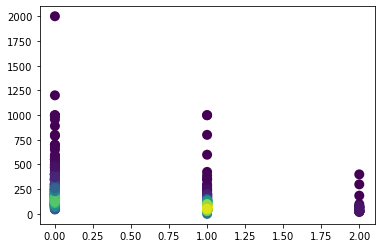

In [12]:
# Calculate the point density sample, as expected, Entire apartment is the most expensive
#followed by private room and shared room (output uses sample to get snapshot)
x_den = df['room_type_num'].sample(n=1000, random_state = 0)
y_den = df['price'].sample(n=1000, random_state = 0)
xy = np.vstack([x_den, y_den])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_den, y_den, c=z, s=100, edgecolor='')
plt.show()
#Entire home/apt' : 0, 'Private room' : 1, 'Shared room': 2

Text(0.5, 1.0, 'Price Distribution Plot')

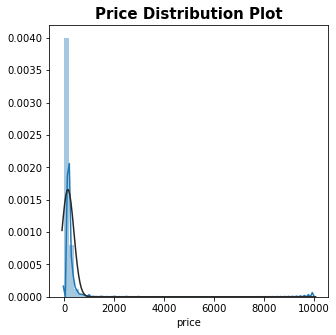

In [13]:
#Illustrate the distribution of the y variable, which is highly skewed
plt.figure(figsize=(5,5))
sns.distplot(df['price'], fit=norm)
plt.title("Price Distribution Plot",size=15, weight='bold')

In [14]:
#prep for regression and feature importance - turning category variables into dummy
hood_dum = pd.get_dummies(df['neighbourhood_group'])
room_dum = pd.get_dummies(df['room_type'])
df = pd.concat([df.reset_index(drop=True), room_dum.reset_index(drop=True), hood_dum.reset_index(drop=True)], axis = 1)

In [15]:
#Create y with transformation - making more normal distribution
df['price_log'] = np.log(df.price+1)

#transformer or log
#y_train = df[['price']]

#pt_y = PowerTransformer()
#pt_y.fit(y_train)
#pt_y_train = df[['price']]
#df['price_transform'] = pt_y.transform(y_train)

Text(0.5, 1.0, 'Log-Price Distribution')

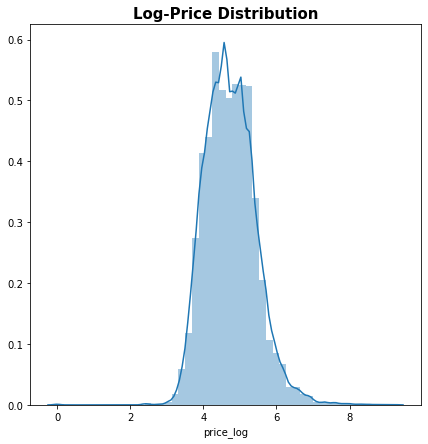

In [16]:
#distribution
plt.figure(figsize=(7,7))
sns.distplot(df['price_log'])
plt.title("Log-Price Distribution",size=15, weight='bold')

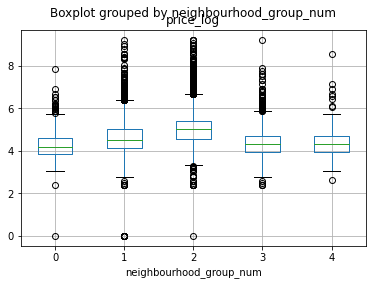

In [17]:
#Compare price_log and neighbourhood, again illustrating Manhattan is most expensive
df.boxplot(column='price_log', by='neighbourhood_group_num');
#'Bronx' : 0, 'Brooklyn' : 1, 'Manhattan': 2, 'Queens': 3, 'Staten Island': 4})

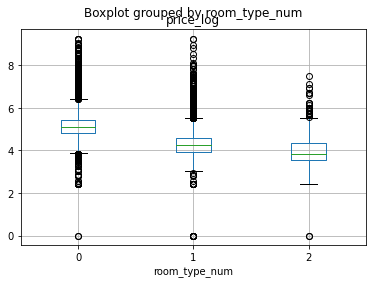

In [18]:
df.boxplot(column='price_log', by='room_type_num');
#'Entire home/apt' : 0, 'Private room' : 1, 'Shared room': 2})

In [19]:
#Drop nonessential but store price first for comparison later
price = df['price']

df.drop(['id', 'price', 'neighbourhood', 'neighbourhood_group', 
         'room_type', 'neighbourhood_group_num', 'room_type_num'],axis = 1, inplace=True)

In [20]:
#review data to be included in modeling
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48895 non-null  int64  
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               48895 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
 8   Entire home/apt                 48895 non-null  uint8  
 9   Private room                    48895 non-null  uint8  
 10  Shared room                     48895 non-null  uint8  
 11  Bronx                           48895 non-null  uint8  
 12  Brooklyn                        

In [21]:
#include all remaining variables in x_values, assign price_log to y
y_value = df.iloc[:, -1]
x_values = df.iloc[:,0:16]

#I was trying some other methods of assinging variables when
#I was working on data transformation/normalization
#y_value = y_train_pt
#x_values = df[x_columns]
#y_value = df[y_columns]

In [22]:
#multicollinearity - linalg.egi (eigenvalues/eigenvectors) 
#Computes the eigenvalues and right eigenvectors of a square array.
corr = df.corr(method = 'pearson')
multicollinearity, V=np.linalg.eig(corr)
list(zip(df.columns,multicollinearity))

[('host_id', 3.0551029575559423),
 ('latitude', 2.2620720402909615),
 ('longitude', 1.8237665086155288),
 ('minimum_nights', 1.536362519707929),
 ('number_of_reviews', 1.422529029319269),
 ('reviews_per_month', 0.2049876124661386),
 ('calculated_host_listings_count', 0.3108619758806565),
 ('availability_365', 0.2742168936389313),
 ('Entire home/apt', 0.39878601505300043),
 ('Private room', 0.7023404454435287),
 ('Shared room', 0.7822087507498761),
 ('Bronx', 0.9899641959893255),
 ('Brooklyn', 1.0254957547480406),
 ('Manhattan', 1.0945712693510898),
 ('Queens', 1.1167340311897036),
 ('Staten Island', -1.7375272655288968e-13),
 ('price_log', 2.623660974262471e-13)]

In [23]:
#Feature importance quick view with simple regression 
#Instantiate and fit.
linreg = LinearRegression()
linreg.fit(x_values, y_value)

# Print the coefficients.
print(linreg.intercept_)
list(zip(x_values.columns, linreg.coef_))

-194.64217509069564


[('host_id', 2.4091074752327223e-10),
 ('latitude', -0.6241711832621076),
 ('longitude', -3.0325948212418425),
 ('minimum_nights', -0.0018996812589390523),
 ('number_of_reviews', -0.00045085566235374006),
 ('reviews_per_month', -0.01191332445450674),
 ('calculated_host_listings_count', -0.000335918448376306),
 ('availability_365', 0.0007421001444465203),
 ('Entire home/apt', 0.636897947780192),
 ('Private room', -0.11373674711611521),
 ('Shared room', -0.5231612006640831),
 ('Bronx', 0.09902825531711368),
 ('Brooklyn', 0.06232071786986326),
 ('Manhattan', 0.36668520042027813),
 ('Queens', 0.18760761653083238),
 ('Staten Island', -0.7156417901380691)]

In [24]:
#below is meant to fit a number of randomized decision trees on various sub-samples of the dataset 
#and uses averaging to improve the predictive accuracy and control over-fitting.
#however, this is just to produce a visual for feature importance and doesn't end up 
#in the final model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_values)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_value, test_size=0.3,random_state=1)

reg = ExtraTreesRegressor(n_estimators=50, random_state=0)
tree_model = reg.fit(X_train, y_train)

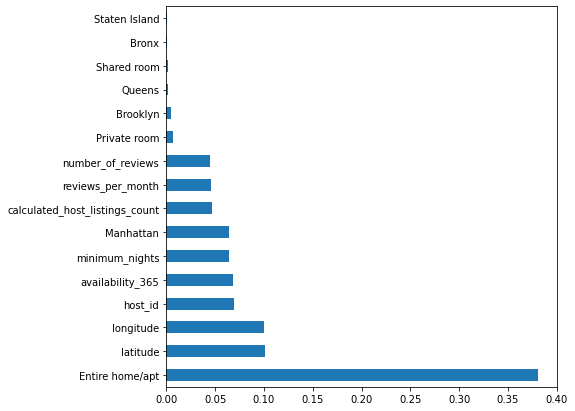

In [25]:
plt.figure(figsize=(7,7))
feat_importances = pd.Series(tree_model.feature_importances_, index=df.iloc[:,:-1].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()
#16 features

In [26]:
# This code is just to explore Decision tree, but does not impact my decision making
# on the final lin reg model - Next steps would include Decision Tree possibiliites
# List of values to try for max_depth:
max_depth_range = list(range(1, 17))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use 5-fold cross-validation with each value of max_depth.
from sklearn.model_selection import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, x_values, y_value, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

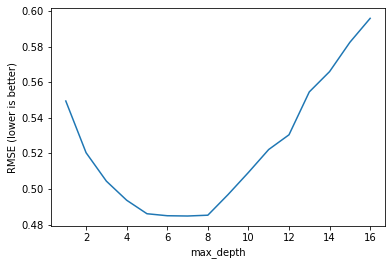

In [27]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [28]:
# This code is just to explore Random Forest, but does not impact my decision making
# on the final lin reg model - Next steps would include Forest model possibiliites
# This also takes like 10 minutes + to run
# List of values to try for max_features:
#feature_range = list(range(1, len(x_values.columns)+1))

# List to store the average RMSE for each value of max_features:
#RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features (Warning: Super slow!).
#for feature in feature_range:
    #rfreg = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=1)
    #MSE_scores = cross_val_score(rfreg, x_values, y_value, cv=10, scoring='neg_mean_squared_error')
    #RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [29]:
# This code is just to explore Random Forest, but does not impact my decision making
# on the final lin reg model - Next steps would include Forest model possibiliites
# Plot max_features (x-axis) versus RMSE (y-axis).

#plt.plot(feature_range, RMSE_scores);

#plt.xlabel('max_features');
#plt.ylabel('RMSE (lower is better)');

In [30]:
# Show the best RMSE and the corresponding max_features.
#sorted(zip(RMSE_scores, feature_range))[0]

In [31]:
#Linear regression model with k fold validation, recursive feature elimination, and GridSearchCV

def lin_reg(X_input, y_input):
     
    #13    
    param = {'n_features_to_select': list(range(1,13))}
    
    #All scorer objects follow the convention that higher return 
    #values are better than lower return values. Thus metrics which 
    #measure the distance between the model and the data, like 
    #metrics.mean_squared_error, are available as neg_mean_squared_error 
    #which return the negated value of the metric.
    
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 
               'neg_root_mean_squared_error', 'r2']
    
    #Standard Scaler doesn't work well with a pre transformed y value (using np.log) 
    #If I leave scaler in here, transforming predicted y values back into meaningful outputs
    #becomes much harder
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X_input)

    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_input, random_state = 50)
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, random_state = 50)

    
    lr = LinearRegression()
    #recursive feature elimination
    rfe = RFE(lr)
    
    folds = KFold(n_splits = 5, shuffle = True, random_state = 50) 
    
    model_cv = GridSearchCV(estimator = rfe,
                            param_grid = param,
                            scoring = scoring, refit = 'neg_root_mean_squared_error',
                            cv = folds, 
                            verbose = 1, 
                            return_train_score=True) 
    
    #final model would just be trained with X_input and y_input
    final_lin_reg = model_cv.fit(X_train, y_train)
    
    y_pred = final_lin_reg.predict(X_test)
    
    print ('~Mean Squared Error~')
    print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('~R Squared~')
    print (metrics.r2_score(y_test, y_pred))
    print ('~Best Score~')
    print (model_cv.best_score_)
    return(final_lin_reg)

In [32]:
gs_lin_model = lin_reg(x_values, y_value)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


~Mean Squared Error~
0.5077665075705322
~R Squared~
0.46708106469534794
~Best Score~
-0.5061393428129415


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    4.9s finished


In [33]:
#variables included in the model have a rank of 1, all others are not included
list(zip(x_values.columns, gs_lin_model.best_estimator_.ranking_))

[('host_id', 5),
 ('latitude', 1),
 ('longitude', 1),
 ('minimum_nights', 1),
 ('number_of_reviews', 3),
 ('reviews_per_month', 1),
 ('calculated_host_listings_count', 4),
 ('availability_365', 2),
 ('Entire home/apt', 1),
 ('Private room', 1),
 ('Shared room', 1),
 ('Bronx', 1),
 ('Brooklyn', 1),
 ('Manhattan', 1),
 ('Queens', 1),
 ('Staten Island', 1)]

In [34]:
#Inverse transform predicted y value to be meaningful in real world
my_index = 15

In [35]:
#trying to inverse the y variable transformation
print ('~Listed Price~')
print(price[my_index])
y_pred = gs_lin_model.predict([x_values.loc[my_index]])
pred_reversed = math.exp(y_pred)
print ('~Predicted Price~')
print(pred_reversed)

~Listed Price~
140
~Predicted Price~
143.73098936842607


In [36]:
#the inverse_transform returned pred_reversed nan for the y predcitions
#if I was using PowerTransformer rather than np.log transform
#my_index = 10
#print(price[my_index])
#y_pred = gs_lin_model.predict([x_values.loc[my_index]])
#print(y_pred)
#pred_reversed = pt_y.inverse_transform(y_pred.reshape(-1,1))
#print(pred_reversed)

In [37]:
#Ridge regression model with k fold validation, recursive feature elimination, and GridSearchCV

def ridge_reg(X_input, y_input):
     
    #13    
    param = {'n_features_to_select': list(range(1,13))}
    
    #All scorer objects follow the convention that higher return 
    #values are better than lower return values. Thus metrics which 
    #measure the distance between the model and the data, like 
    #metrics.mean_squared_error, are available as neg_mean_squared_error 
    #which return the negated value of the metric.
    
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 
               'neg_root_mean_squared_error', 'r2']
    
    #Standard Scaler doesn't work well with a pre transformed y values (using np.log) 
    #If I leave scaler in here, transforming predicted y values back into meaningful outputs
    #becomes much harder
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X_input)

    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_input, random_state = 50)
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, random_state = 50)

    
    ridge = Ridge()
    #recursive feature elimination
    rfe = RFE(ridge)
    
    folds = KFold(n_splits = 5, shuffle = True, random_state = 50) 
    
    model_cv = GridSearchCV(estimator = rfe,
                            param_grid = param,
                            scoring = scoring, refit = 'neg_root_mean_squared_error',
                            cv = folds, 
                            verbose = 1, 
                            return_train_score=True) 
    
    #final model would just be trained with X_input and y_input
    final_ridge_reg = model_cv.fit(X_train, y_train)
    
    y_pred = final_ridge_reg.predict(X_test)
    
    print ('~Mean Squared Error~')
    print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('~R Squared~')
    print (metrics.r2_score(y_test, y_pred))
    print ('~Best Score~')
    print (model_cv.best_score_)
    return(final_ridge_reg)

In [38]:
#Lasso regression model with k fold validation, recursive feature elimination, and GridSearchCV

def lasso_reg(X_input, y_input):
     
    #13    
    param = {'n_features_to_select': list(range(1,13))}
    
    #All scorer objects follow the convention that higher return 
    #values are better than lower return values. Thus metrics which 
    #measure the distance between the model and the data, like 
    #metrics.mean_squared_error, are available as neg_mean_squared_error 
    #which return the negated value of the metric.
    
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 
               'neg_root_mean_squared_error', 'r2']
    
    #Standard Scaler doesn't work well with a pre transformed y values (using np.log) 
    #If I leave scaler in here, transforming predicted y values back into meaningful outputs
    #becomes much harder
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X_input)

    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_input, random_state = 50)
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, random_state = 50)

    
    lasso = Lasso()
    #recursive feature elimination
    rfe = RFE(lasso)
    
    folds = KFold(n_splits = 5, shuffle = True, random_state = 50) 
    
    model_cv = GridSearchCV(estimator = rfe,
                            param_grid = param,
                            scoring = scoring, refit = 'neg_root_mean_squared_error',
                            cv = folds, 
                            verbose = 1, 
                            return_train_score=True) 
    
    #final model would just be trained with X_input and y_input
    final_lasso_reg = model_cv.fit(X_train, y_train)
    
    y_pred = final_lasso_reg.predict(X_test)
    
    print ('~Mean Squared Error~')
    print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ('~R Squared~')
    print (metrics.r2_score(y_test, y_pred))
    print ('~Best Score~')
    print (model_cv.best_score_)
    return(final_lasso_reg)

In [ ]:
print('*****Linear Regression')
gs_lin_model = lin_reg(x_values, y_value)

print('*****Ridge Regression')
gs_ridge_model = ridge_reg(x_values, y_value)

print('*****Lasso Regression')
gs_lasso_model = lasso_reg(x_values, y_value)

In [ ]:
#*****Linear Regression
#~Mean Squared Error~
#0.5077665075705322
#~R Squared~
#0.46708106469534794
#~Best Score~
#-0.5061393428129415

#*****Ridge Regression
#~Mean Squared Error~
#0.5077824027405704
#~R Squared~
#0.46704769908515953
#~Best Score~
#-0.5061463761254528

#*****Lasso Regression
#~Mean Squared Error~
#0.6868897517061688
#~R Squared~
#0.024769842712673018
#~Best Score~
#-0.6862548329579061

In [39]:
#Establish final model

#Linear regression model with k fold validation, recursive feature elimination, and GridSearchCV

def lin_reg_final(X_input, y_input):
     
    #13    
    param = {'n_features_to_select': list(range(1,13))}
    
    #All scorer objects follow the convention that higher return 
    #values are better than lower return values. Thus metrics which 
    #measure the distance between the model and the data, like 
    #metrics.mean_squared_error, are available as neg_mean_squared_error 
    #which return the negated value of the metric.
    
    scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 
               'neg_root_mean_squared_error', 'r2']
    
    #Standard Scaler doesn't work well with a pre transformed y values (using np.log) 
    #If I leave scaler in here, transforming predicted y values back into meaningful outputs
    #becomes much harder
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X_input)

    #X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_input, random_state = 50)
    #X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, random_state = 50)

    
    lr = LinearRegression()
    #recursive feature elimination
    rfe = RFE(lr)
    
    folds = KFold(n_splits = 5, shuffle = True, random_state = 50) 
    
    model_cv = GridSearchCV(estimator = rfe,
                            param_grid = param,
                            scoring = scoring, refit = 'neg_root_mean_squared_error',
                            cv = folds, 
                            verbose = 1, 
                            return_train_score=True) 
    
    #final model would just be trained with X_input and y_input
    final_lin_reg = model_cv.fit(X_input, y_input)
    
    #y_pred = final_lin_reg.predict(X_test)
    
    #print ('~Mean Squared Error~')
    #print (np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ('~R Squared~')
    #print (metrics.r2_score(y_test, y_pred))
    print ('~Best Score~')
    print (model_cv.best_score_)
    return(final_lin_reg)

In [40]:
gs_lin_model_final = lin_reg_final(x_values, y_value)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


~Best Score~
-0.5065898096157534


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    6.6s finished
